In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from cycler import cycler

import json
import os
import copy

In [14]:
dtw_attack = "slicing"

In [15]:
with open('SW-DTW_evaluation_weightings_' + dtw_attack + '.json', 'r') as read_file:
    data = json.load(read_file)
    
data_stress = data["stress"]["1"] + data["stress"]["3"] + data["stress"]["5"]

stress_weights = list()
for weights in data_stress:
    weight = list()
    for sensor in weights:
        weight.append(weights[sensor])
    stress_weights.append(weight)

data_non_stress = data["non-stress"]["1"] + data["non-stress"]["3"] + data["non-stress"]["5"]

non_stress_weights = list()
for weights in data_non_stress:
    weight = list()
    for sensor in weights:
        weight.append(weights[sensor])
    non_stress_weights.append(weight)

data = [['ACC', 'BVP', 'EDA', 'TEMP'], ('non-stress', non_stress_weights), ('stress', stress_weights)]

In [16]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'

        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

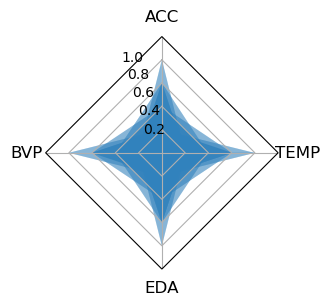

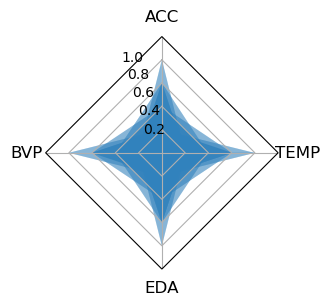

In [17]:
N = len(data[0])
theta = radar_factory(N, frame='polygon')

plt.rc('font', size=12)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", [plt.cm.tab20c.colors[0]])

spoke_labels = data.pop(0)
for title, case_data in data:
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)

    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_ylim(0, 1.0)
    ax.tick_params(axis='y', labelsize=8)
    plt.setp( ax.get_yticklabels(), visible=False)
    yfontsize = 10
    ax.text(0.3, 0.21, 0.2, color='black', fontsize=yfontsize, ha='center', va='center')
    ax.text(0.3, 0.38, 0.4, color='black', fontsize=yfontsize, ha='center', va='center')
    ax.text(0.3, 0.54, 0.6, color='black', fontsize=yfontsize, ha='center', va='center')
    ax.text(0.3, 0.7, 0.8, color='black', fontsize=yfontsize, ha='center', va='center')
    ax.text(0.3, 0.86, 1.0, color='black', fontsize=yfontsize, ha='center', va='center')
    #ax.set_title(title,  position=(0.5, 1.1), ha='center')

    for d in case_data:
        #line = ax.plot(theta, d)
        ax.fill(theta, d, alpha=0.25, label='_nolegend_')

    ax.set_varlabels(spoke_labels)

    plt.savefig("./weights_"+title+"_"+dtw_attack+".pdf", format="pdf", transparent=True, bbox_inches='tight')
    plt.show()